# Time Series Analysis on Pollutant Gases
## Table of Contents
- Problem Statement
- Dataset Details
- Background Research on Pollutant Gases
- Exploratory Data Analysis
- Data Pre-processing
- Modelling
- Model Tuning
- Model Analysis
- Kaggle Submission

## References
- AIML Module Notes
- Hyndman, R.J., & Athanasopoulos, G. (2021) Forecasting: principles and practice, 3rd edition, OTexts: Melbourne, Australia. OTexts.com/fpp3. 
- Statsmodels Documentation
- Pandas documentation
- Scikit Learn documentation
- Wiley Data Analyst Time Series and Forecasting Notes
- [World Health Organisation](https://www.who.int/health-topics/air-pollution#tab=tab_1)
- MAAH, Balz; ZHOU, Zimu; and THIELE, Lothar. A survey on sensor calibration in air pollution monitoring 
deployments. (2018). IEEE Internet of Things. 5, (6), 4857-4870. Research Collection School Of 
Information Systems. 
- [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Air+Quality)
- [S. De Vito, E. Massera, M. Piga, L. Martinotto, G. Di Francia,
On field calibration of an electronic nose for benzene estimation in an urban pollution monitoring scenario](https://www.researchgate.net/publication/235641830_On_field_calibration_of_an_electronic_nose_for_benzene_estimation_in_an_urban_pollution_monitoring_scenario)
- [Climate of Italy](https://en.wikipedia.org/wiki/Climate_of_Italy)
- [Nitrogen Oxide Emission Trends for Italy](https://www.statista.com/statistics/809161/nitrogen-oxides-nox-emission-trend-in-italy/)
- [NOx Emissions - European Environment Agency](https://www.eea.europa.eu/data-and-maps/indicators/eea-32-nitrogen-oxides-nox-emissions-1/assessment.2010-08-19.0140149032-3#:~:text=The%20sectors%20responsible%20for%20the,distribution%27%20(contributing%2027%25).)
- [Effect of Environmental Temperature and Humidity
on Different Metal Oxide Gas Sensors at Various
Gas Concentration Levels, Abdulnasser Nabil Abdullah et al 2020 IOP Conf. Ser.: Mater. Sci. Eng. 864
012152](https://iopscience.iop.org/article/10.1088/1757-899X/864/1/012152/pdf)
- [Choosing the order of an ARIMA model](https://arauto.readthedocs.io/en/latest/how_to_choose_terms.html#the-acf-and-pacf-function)

## Library Imports

In [176]:
# Statistical Analysis
import numpy as np
import pandas as pd
import statsmodels.tsa as tsa
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.tools import diff
import statsmodels.api as sm
# Graphical Analysis
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Model Validation
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

sns.set()
plt.rcParams['figure.figsize'] = (13, 8)

import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)
warnings.simplefilter('ignore', FutureWarning)

## Problem Statement
![Air Pollution](https://assets.nrdc.org/sites/default/files/styles/header_background/public/health4_26_airpollguide_istock_2796602_900x600px.jpg?itok=vCwn8tgz)

Air pollution is a problem that affects major cities around the world. There are many different types of air pollutants, which usually come in the form of gases like carbon monoxide, carbon dioxide, sulfur dioxide, nitrogen oxides, CFCss, and other chemicals. 

Bad air quality in cities can lead to health problems for residents living there, including respiratory diseases and even death. In fact, according to the World Health Organisation, air pollution accounts for 4.2 million deaths every year [[1]](https://www.who.int/health-topics/air-pollution#tab=tab_1). To keep track of air pollution, governments invest heavily in sensors, which are used to measure the level of air pollution of different pollutants. However, good quality sensors are expensive, and thus governments rely on cheap sensors which have low accuracy. [[2]](https://ink.library.smu.edu.sg/cgi/viewcontent.cgi?article=5536&context=sis_research)

Our task is to create a time series model that is capable of forecasting air pollution levels. If our model can forecast air pollution data with a reasonable accuracy, it would be a valuable tool (more accurate than low quality sensors) for health authorities to guage the impact of air pollution, and warn the public of any health threats. 

To be more concrete, our task is to predict the average sensor response of Carbon Monoxide, Non Metanic HydroCarbons, Nitrogen Oxides, and Ozone. (Note that sensor response is not the same as the concentration.)

### Carbon Monoxide (CO)
Carbon monoxide (CO)—a colorless, odorless, tasteless, and toxic air pollutant—is produced in the incomplete combustion of carbon-containing fuels, such as gasoline, natural gas, oil, coal, and wood. Breathing the high concentrations of CO typical of a polluted environment leads to reduced oxygen (O2) transport by hemoglobin and has health effects that include headaches, increased risk of chest pain for persons with heart disease, and impaired reaction timing. [[3]](https://www.nap.edu/read/10378/chapter/3)

## Data Understanding
The dataset appears to be sourced from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Air+Quality), but with data downsampled from an hourly frequency to a daily frequency, and several features omitted. The description and date range of the data appears to match up, the scales of the data are the same,and even the method of marking missing values is the same. Furthermore, downsampling that dataset leads to a dataset that has a similar size as the one provided. 

If we make an assumption that the data set is the same, we can say that the data was collected from chemical sensor data collected over the course of March 2004 to February 2005. [[4]](https://www.sciencedirect.com/science/article/abs/pii/S0925400507007691?via%3Dihub)

![Operation of a MOS Type Gas Sensor](https://www.figaro.co.jp/en/img/development/handoutai/shikumi.gif)

The sensors used are metal oxide sensors, which use a sensing layer, where gases are either absorbed or desorbed. This reaction causes a change in the conductivity of the material. [[4]](https://www.sciencedirect.com/science/article/abs/pii/S0925400507007691?via%3Dihub). The sensor device then uses this reading to estimate the concentration of that particular gas in the surroundings.

Our dataset contains the following attributes:
| Attribute | Description |
|---|---|
| Date | Day/Month/Year Format, which is different from default Pandas format |
| T | Temperature in Degree Celcius |
| RH | Relative Humidity (%) |
| Gas | Type of Gas Measured: CO (Carbon Monoxide), NMHC (Non Metanic HydroCarbons), NOx (Nitrogen Oxides), O3 (Ozone) |
| Value | Daily Averaged Estimated Concentration of Pollutants. Note that the concentration for Carbon Monoxide would be in a different unit |

Our target attribute would be the `Value` attribute.

## Data Ingestion
We will start out by loading in our data. We must take note here that the date formatting of the data does not follow the standard Pandas convention. As such, we must specify the date formatting to convert the date attribute to a datetime.

Since many Pandas time series methods only work if the index of our data is a time series, we will set the date attribute as the index.

Also, we will set all -200 values as missing values, as specified in the dataset source.

In [114]:
df = pd.read_csv("train.csv", na_values=[-200])
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")
df.set_index("Date", inplace=True)
df.head()

,T,RH,Gas,Value
Date,,,,
2004-03-10,12.020833,54.883334,CO,1316.500000
2004-03-11,9.833333,64.069791,CO,1244.062500
2004-03-12,11.292708,51.107292,CO,1281.562500
2004-03-13,12.866319,51.530903,CO,1330.555556
2004-03-14,16.016667,48.843750,CO,1360.927083


We will also make a pivoted version of our data. This is useful for later data analysis for each day.

In [115]:
daily_volumes = df.pivot(columns='Gas', values='Value')
daily_volumes

Gas,CO,NMHC,NOx,O3
Date,,,,
2004-03-10,1316.500000,912.250000,1167.250000,1096.041667
2004-03-11,1244.062500,851.802083,1277.187500,885.031250
2004-03-12,1281.562500,1008.229167,1101.718750,1084.218750
2004-03-13,1330.555556,992.822917,993.159722,1245.781250
2004-03-14,1360.927083,943.854167,1001.104167,1234.177083
...,...,...,...,...
2005-01-27,911.777778,703.312500,997.059028,691.475694
2005-01-28,592.864583,434.350694,635.225694,429.375000
2005-01-29,769.625000,518.093750,1024.666667,418.072917


## Exploratory Data Analysis
We will then perform an exploratory data analysis, to get a better sense of our data. There are some questions that we want to ask, including:

**General Dataset Info**
1. How many rows and atttributes are there in the dataset?
2. What are the data types of each attribute, and are they correct?
3. What is the frequency of the data, can we assume that it is daily?
4. How many missing values are there in the data?
5. Where are the missing values located?

**Uni-variate Analysis**
1. What are the summary statistics of our data, and what does it tell us about our data?
2. What does the distribution of the data look like? Do the attributes appear to follow a particular distribution?
3. Are there any outliers in the data?

**Bi-variate Analysis**
1. Is there any correlation between sensor readings and the temperature/relative humidity?
2. Is there any correlation between the different gases?

**Time Series Data**
1. How does temperature and relative humidity change with time?
2. How do the gas concentrations change with time?

**Checking Assumptions for Time Series Analysis**
1. Is the data stationary?
2. Is there any serial dependency in the data?


In [116]:
df_eda = df.copy()

### General Dataset Info

#### How many rows and attributes are there in the dataset?

In [117]:
rows, cols = df_eda.shape
print(f"There are {rows} rows and {cols} attributes in the dataset.")

There are 1312 rows and 4 attributes in the dataset.


Note that if we consider date as an attribute, we will have 5 attributes.

#### What are the data types of each attribute, and are they correct?

In [118]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1312 entries, 2004-03-10 to 2005-01-31
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T       1288 non-null   float64
 1   RH      1288 non-null   float64
 2   Gas     1312 non-null   object 
 3   Value   1288 non-null   float64
dtypes: float64(3), object(1)
memory usage: 51.2+ KB


As we have converted the Date from an object to a datetime, we see that all the data types are correct.

#### What is the frequency of the data, can we assume that it is daily?

In [119]:
df_eda.index

DatetimeIndex(['2004-03-10', '2004-03-11', '2004-03-12', '2004-03-13',
               '2004-03-14', '2004-03-15', '2004-03-16', '2004-03-17',
               '2004-03-18', '2004-03-19',
               ...
               '2005-01-22', '2005-01-23', '2005-01-24', '2005-01-25',
               '2005-01-26', '2005-01-27', '2005-01-28', '2005-01-29',
               '2005-01-30', '2005-01-31'],
              dtype='datetime64[ns]', name='Date', length=1312, freq=None)

Although the frequency is not specified in the DatetimeIndex, we can see that each row represents a single day.

In [120]:
len(daily_volumes) - len(daily_volumes.asfreq("D"))

0

We see that there is an entry for each day.

#### How many missing values are there in the data?
As noted in the data description, missing values in the dataset are pre-filled with a value of -200. After marking these values as missing, how many missing values are there in the data?

In [121]:
df_eda.isna().sum()

T        24
RH       24
Gas       0
Value    24
dtype: int64

In [122]:
df_eda.isna().sum() / len(df_eda) * 100

T        1.829268
RH       1.829268
Gas      0.000000
Value    1.829268
dtype: float64

We see that there are 24 missing values, which form 1.82% of our data.

#### Where are the missing values located?
We note from our initial look that the number of missing values is the same for each attribute. 

In [123]:
df_eda[df_eda.isna().any(axis=1)]

,T,RH,Gas,Value
Date,,,,
2004-06-20,NaN,NaN,CO,NaN
2004-08-27,NaN,NaN,CO,NaN
2004-12-15,NaN,NaN,CO,NaN
2004-12-16,NaN,NaN,CO,NaN
2005-01-03,NaN,NaN,CO,NaN
2005-01-04,NaN,NaN,CO,NaN
2004-06-20,NaN,NaN,NMHC,NaN
2004-08-27,NaN,NaN,NMHC,NaN
2004-12-15,NaN,NaN,NMHC,NaN


It appears that all the missing values are from the same days. This is likely because all the sensors are located in the same device. Hence if one sensor does not work, the data is missing for all attributes.

### Uni-variate Analysis

#### What are the summary statistics of our data, and what does it tell us about our data?

In [124]:
df_eda.describe()

,T,RH,Value
count,1288.000000,1288.000000,1288.000000
mean,15.578425,44.343425,958.974298
std,23.385561,28.453860,237.401354
min,-191.164583,-188.839583,-155.583333
25%,12.585417,37.059375,816.646701
50%,18.993750,46.452083,968.067708
75%,25.762500,58.032292,1104.153646
max,32.997917,81.104167,1795.291667


- The mean temperature recorded is 15.57 Degrees Celcius, but the min temperature -191.164 degrees celcius. This appears to be an extreme outlier.
- The median temperature is higher than the mean temperature, suggesting a negatively skewed distribution.
- The temperatures seen are mostly consistent with the [climate of Italy](https://en.wikipedia.org/wiki/Climate_of_Italy). This suggests that the temperatures with extreme negative values are actually outliers (possibly sensor miscalibrations), and not the result of extreme cooling in the sensor device.
- The mean relative humidity is 44.34%, which is lower than the median relative humidity. This might suggest a negatively skewed distribution of the data.
- If relative humidity is in percentage, having a negative percentage relative humidity does not make sense. Consider that relative humidity is the **ratio of how much water vapour is in the air and how much water vapor the air could possibly contain at a given temperature**; How is it possible then that it is negative? Logically this must be an error (again, possibly a result of faulty sensors), and any negative values for Relative Humidity should be removed.
- Furthermore, according to the researchers who collected the data, the sensors used are only rated for a temperature of -20 to 50 degrees celcius, and a relative humidity of 10% to 90%. Hence, it is safe to consider any values out of this range as being inaccurate anyways.

![sensor specifications](sensor_specifications.png)

In [125]:
daily_volumes.describe()

Gas,CO,NMHC,NOx,O3
count,322.000000,322.000000,322.000000,322.000000
mean,1074.034862,932.706457,831.478477,997.677396
std,192.346012,184.942814,200.428180,287.769529
min,-142.666667,-153.458333,-155.583333,-143.697917
25%,981.338542,839.421875,712.370660,809.098958
50%,1084.482639,948.649306,826.208333,1005.692708
75%,1188.539062,1061.109375,944.387153,1183.658854
max,1513.208333,1355.104167,1678.687500,1795.291667


- In our data, we see that there are negative values for each gas as their min estimated concentration
- Recall that for the metal oxide sensors used to collect this data, we get these readings by measuring the change in resistance of the metal oxide material due to a chemical reaction between the metal oxide and the gas and using it to estimate the concentration of pollutants. Thus the "value" attribute in our data is supposed to be an estimated concentration in $\mu/m^3$ (for Nitrogen Oxides and Ozone), or $mg/m^3$ (for Carbon Monoxide)
- As such, a negative concentration does not make any sense. Given that the sensor is only giving a rough estimate of the concentration, it is highly possible that these negative values came about due to sensor errors. 
- The mean values are similar to their median, suggesting that the distribution is not highly skewed; The only outliers come from the negative values.
- Since the values are technically in different units, we may also want to perform scaling of our data.

#### What does the distribution of the data look like? Do the attributes appear to follow a particular distribution?

array([[<AxesSubplot:title={'center':'T'}>,
        <AxesSubplot:title={'center':'RH'}>]], dtype=object)

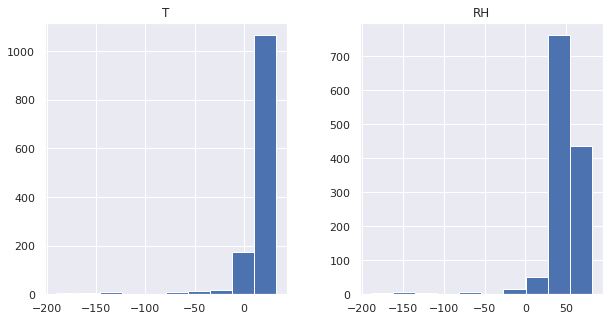

In [126]:
df_eda[['T', 'RH']].hist(figsize=(10, 5))

<AxesSubplot:>

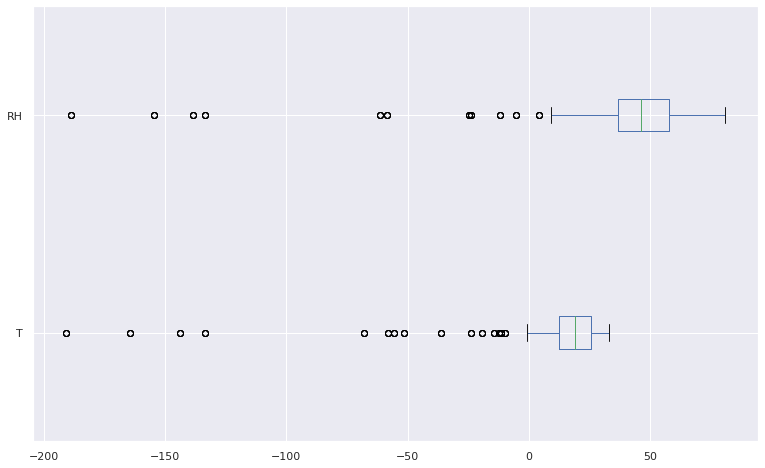

In [127]:
df_eda[['T', 'RH']].plot(kind='box', vert=False)

- We observe that both Temperature and Relative Humidity values are negatively skewed.
- This seems to be mostly the result of outliers, as the box plot, shows that excluding outliers, the distributions are much more symmetrical, but still slightly negatively skewed. This is because of colder temperatures in the Winter, and months with relatively little humidity.

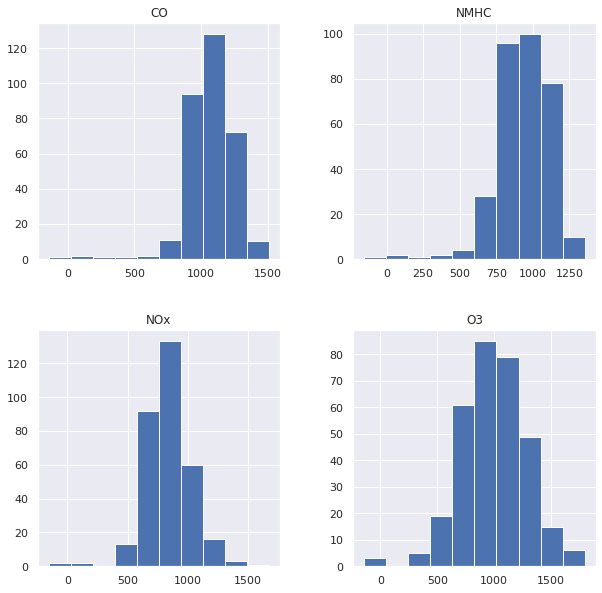

In [128]:
daily_volumes.hist(figsize=(10,10))
plt.show()

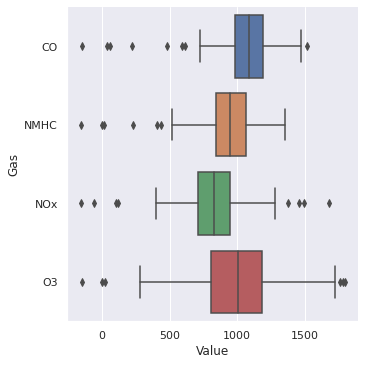

In [129]:
sns.catplot(data=df_eda, x='Value', y='Gas', kind='box')

- For the most part, each gas shares a similar distribution for their values, as their boxes mostly overlap. 
- We again see evidence on extreme outliers, mostly below the lower fence.

#### Are there any outliers in the data?
From our previous analysis, we noted the presense of outliers in all numerical features. We had already come to a few conclusions based on our background research:
- These values are unnatural, and are impossible occurances in real life:
    - The freezing outlier temps are too cold for Italy's, and even too cold for the Artic
    - It is impossible for relative humidity to be negative
    - The sensors used to collect the data, are not rated for these extreme outlier temperatures/humdity
    - A negative concentration (which is what the sensors are trying to estimate), is also ridiculous. 
- Thus, we hypothesise that these come as a result of sensor errors, resulting in a wrong sensor reading.

To test this hypothesis, we want to answer a few questions:
1. How many of these extreme outliers are there?
2. When do these outliers happen? Do they happen indepedently, or is there some pattern to the outlier data?

For this, we will use Tukey's Fences to denote any outliers. Recall that by this criterion, an outlier is any data that founds outside the range $[Q_1 - k(Q_3 - Q_1), Q_3 + k(Q_3 - Q_1)]$. We use Tukey's Fences, as this method is applicable to skewed data since it makes no distributional assumptions and it does not depend on a mean or standard 
deviation. In this case, we will look at the extreme outliers, setting $k=3$. We will also mark negative RH and Value as outliers, since in the context here, they are definitely wrong.

In [130]:
def mark_outliers(df, col, k=1.5):
    df_col = df[col]
    upper_quartile = df_col.quantile(.75)
    lower_quartile = df_col.quantile(.25)
    interquartille_range = upper_quartile - lower_quartile
    upper_fence = upper_quartile + (k * interquartille_range)
    lower_fence = lower_quartile - (k * interquartille_range)
    outliers = ((df_col > upper_fence) | (df_col < lower_fence))
    return outliers

In [131]:
outliers_list = []
df_outliers = df_eda.copy()
for col in ('T', 'RH', 'Value'):
    outliers = mark_outliers(df_outliers, col, 3)
    outliers_list.append(outliers)
    df_outliers[f'Outlier ({col})'] = outliers
outliers_list.append((df['RH'] < 0))
outliers_list.append((df['Value'] < 0))
df_outliers["Outlier"] = np.logical_or.reduce(outliers_list)
df_outliers = df_outliers[df_outliers["Outlier"] == True]
df_outliers.head()

,T,RH,Gas,Value,Outlier (T),Outlier (RH),Outlier (Value),Outlier
Date,,,,,,,,
2004-04-09,-191.164583,-188.839583,CO,-142.666667,True,True,True,True
2004-05-25,-23.920833,-24.786458,CO,747.781250,False,False,False,True
2004-05-26,-57.951736,-61.500694,CO,611.284722,True,True,False,True
2004-06-19,-68.069792,-58.296875,CO,481.753472,True,True,False,True
2004-06-21,-12.148958,-5.416667,CO,758.739583,False,False,False,True


###### How many outliers are there?

In [132]:
df_outliers.shape

(44, 8)

We observe that in total, our data has 44 rows that contain at least one outlier value.

###### Is there any pattern associated with these outliers?

In [133]:
df_outliers

,T,RH,Gas,Value,Outlier (T),Outlier (RH),Outlier (Value),Outlier
Date,,,,,,,,
2004-04-09,-191.164583,-188.839583,CO,-142.666667,True,True,True,True
2004-05-25,-23.920833,-24.786458,CO,747.781250,False,False,False,True
2004-05-26,-57.951736,-61.500694,CO,611.284722,True,True,False,True
2004-06-19,-68.069792,-58.296875,CO,481.753472,True,True,False,True
2004-06-21,-12.148958,-5.416667,CO,758.739583,False,False,False,True
2004-08-26,-144.072917,-138.672917,CO,61.083333,True,True,False,True
2004-09-08,-133.732292,-133.684375,CO,225.208333,True,True,False,True
2004-12-14,-51.363194,-11.956250,CO,810.489583,True,False,False,True
2004-12-17,-164.510417,-154.515625,CO,36.281250,True,True,False,True


From an initial look, all of our extreme outliers have an extremely cold temperature. 

##### What should be done about the outliers?

According to [research](https://iopscience.iop.org/article/10.1088/1757-899X/864/1/012152/pdf), when there are changes in the temperature and relative humidity, it causes a change in the resistance of the sensor, thus causing the readings to drift. This suggest that outside of the operating range of the sensors used (-20 to 50 degrees in Temp, and 10-90% relative humidity), the readings of the sensor would be less accurate. 

There are a few approaches we can take here:
- Ignore the outliers. But this is likely a bad idea, as at the very least, the outlier temperature and relative humidity are definitely wrong.
- Mark the outlier value, and replace it with another value (e.g. the previous value)
- Mark any row with an outlier, and replace the whole row. This assumes that if for example the relative humidity reading is wrong, then the entire set of data for that day is wrong.

I will pick the second option (but will try out the third later on to see if it improves model performance). The reason why is because just because the temp or relative humidity reading is wrong, it does not mean that the gas concentration reading is wrong. It just means that we don't know the actual temperature or relative humidity when the gas reading was taken.

### Bi-variate Analysis

We also want to look at the relationships between the different variables. Since we are only dealing with numerical variables, we can make use of Pearson's correlation to measure the linear relationship between variables. For a more accurate look, let's filter out our extreme outliers since they are likely wrong data anyways, and make up a small part of our data.

#### Is there any correlation between sensor readings and the temperature/relative humidity?

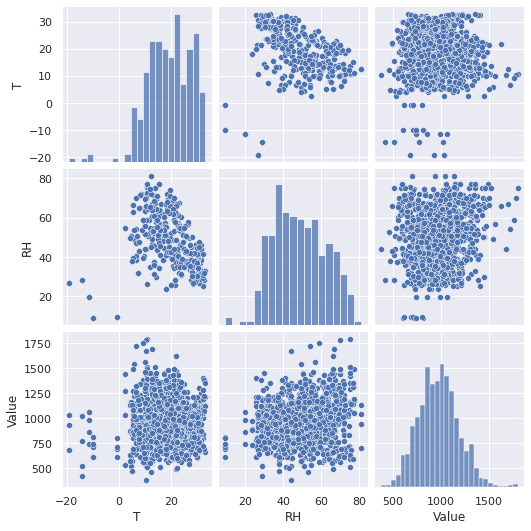

In [134]:
df_outliers_none = df_eda.copy()
df_outliers_none["Outlier"] = np.logical_or.reduce(outliers_list)
df_outliers_none = df_outliers_none[df_outliers_none["Outlier"] == False]
df_outliers_none.drop('Outlier', axis=1, inplace =True) 
sns.pairplot(df_outliers_none)
plt.show()

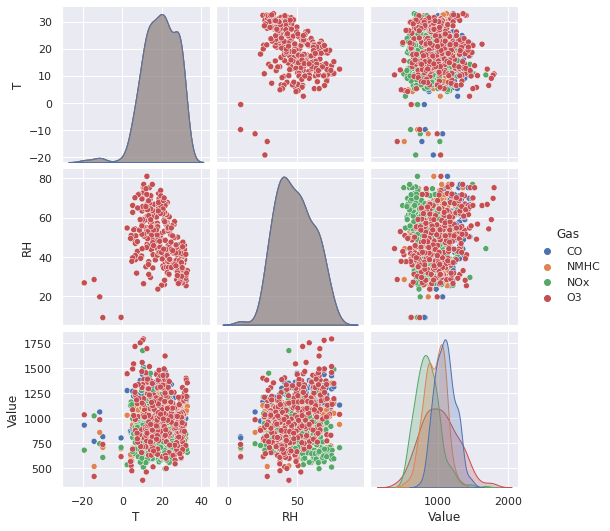

In [135]:
sns.pairplot(df_outliers_none, hue='Gas')

From the scatterplots, we can't spot any relationship between the Value and other attributes.

<AxesSubplot:>

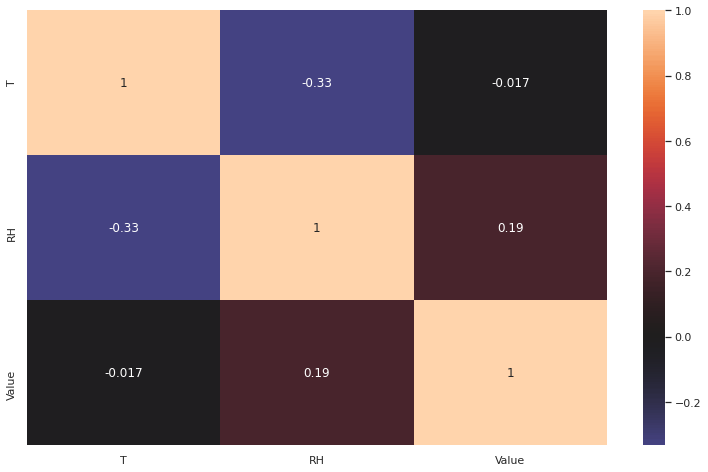

In [136]:
correlation = df_outliers_none.corr()

sns.heatmap(correlation, annot=True, center=0)

- There is only a weak positive linear relationship between relative humidity and the value, and almost no relationship between temperature and the value.
- There is some correlation between temperature and relative humidity. This makes complete sense as relative humidity depends on the temperature (more specifically, the amount of water vapour that the air can store at that given temperature). In fact, relative humidity is inversely proportional to temperature, which explains the negative correlation coefficient.
- All this suggests that OLS Regression would be a bad way to predict the value of the sensor, and that we should stick with using normal time series models.

####  Is there any correlation between the different gases?

<AxesSubplot:xlabel='Gas', ylabel='Gas'>

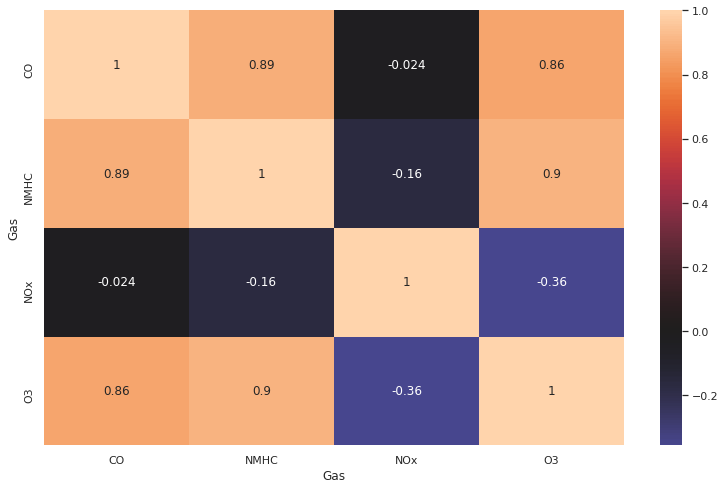

In [137]:
gas_corr = daily_volumes.corr()

sns.heatmap(gas_corr, annot=True, center=0)

- We observe a strong positive linear relationship between the concentration of Carbon Monoxide, and the concentration of Ozone
- The same goes for Non-metanic Hydrocarbons and Ozone
- There is a moderately strong negative linear relationship between the concentration of Nitrogen Oxides and Ozone
- There is a weak negative linear relationship between the concentration of non-metanic Hydrocarbons and Nitrogen Oxides
- There is almost no relationship between the Concentration of Nitrogen Oxides and and the concentration of Carbon Monoxide.

#### Is there any correlation between the change in concentration of each gas?

### Time Series Analysis

Given the time series nature of our data, we want to find out,
- What is the trend and seasonality of our data?
- What does the autocorrelation function of the Gas values look like?
- Is there evidence of exponential growth in the values?
- Is the data stationary? And if not, how much differencing is required to transform it to a stationary series?

In [138]:
df_stat = df.copy()
# for col in ('T', 'RH', 'Value'):
#     outliers = mark_outliers(df_stat, col, 3)
#     df_stat.loc[outliers, col] = np.nan

impossible_RH = (df_stat['RH'] < 10) | (df_stat['RH'] > 90) 
out_of_range_temp = (df_stat['T'] < -20) | (df_stat['T'] > 50) 
df_stat.loc[out_of_range_temp, 'T'] = np.nan
impossible_Value = df_stat['Value'] < 0
df_stat.loc[impossible_RH, 'RH'] = np.nan
df_stat.loc[impossible_Value, 'Value'] = np.nan

# df_stat = df_stat.fillna(method='ffill')

In [139]:
df_stat_daily = pd.pivot(df_stat, values="Value", columns="Gas")
df_stat_daily[["T", "RH"]] = df_stat[["T", "RH"]].groupby(df_stat.index).mean()
df_stat_daily = df_stat_daily.fillna(method='ffill')
df_stat_daily

Gas,CO,NMHC,NOx,O3,T,RH
Date,,,,,,
2004-03-10,1316.500000,912.250000,1167.250000,1096.041667,12.020833,54.883334
2004-03-11,1244.062500,851.802083,1277.187500,885.031250,9.833333,64.069791
2004-03-12,1281.562500,1008.229167,1101.718750,1084.218750,11.292708,51.107292
2004-03-13,1330.555556,992.822917,993.159722,1245.781250,12.866319,51.530903
2004-03-14,1360.927083,943.854167,1001.104167,1234.177083,16.016667,48.843750
...,...,...,...,...,...,...
2005-01-27,911.777778,703.312500,997.059028,691.475694,5.267708,39.614930
2005-01-28,592.864583,434.350694,635.225694,429.375000,5.267708,39.614930
2005-01-29,769.625000,518.093750,1024.666667,418.072917,-14.272917,28.563542


In [140]:
df_stat_daily['is_weekend'] = df_stat_daily.index.weekday.isin([5, 6])
df_stat_daily

Gas,CO,NMHC,NOx,O3,T,RH,is_weekend
Date,,,,,,,
2004-03-10,1316.500000,912.250000,1167.250000,1096.041667,12.020833,54.883334,False
2004-03-11,1244.062500,851.802083,1277.187500,885.031250,9.833333,64.069791,False
2004-03-12,1281.562500,1008.229167,1101.718750,1084.218750,11.292708,51.107292,False
2004-03-13,1330.555556,992.822917,993.159722,1245.781250,12.866319,51.530903,True
2004-03-14,1360.927083,943.854167,1001.104167,1234.177083,16.016667,48.843750,True
...,...,...,...,...,...,...,...
2005-01-27,911.777778,703.312500,997.059028,691.475694,5.267708,39.614930,False
2005-01-28,592.864583,434.350694,635.225694,429.375000,5.267708,39.614930,False
2005-01-29,769.625000,518.093750,1024.666667,418.072917,-14.272917,28.563542,True


#### Descriptive Statistics

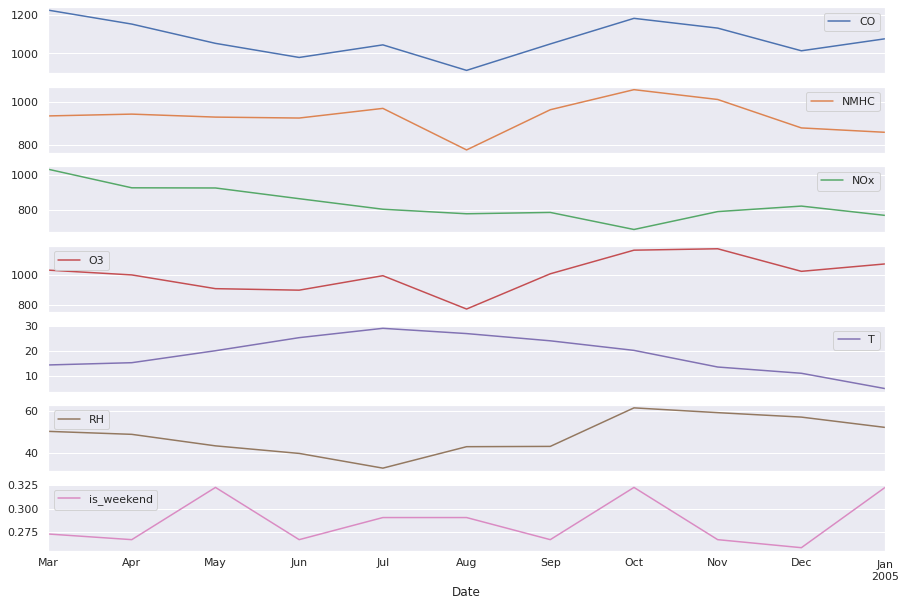

In [141]:
df_stat_daily.resample('M').mean().plot(subplots=True, figsize=(15, 10))
plt.show()

#### Time Plots

##### Temperature

In [142]:
px.line(data_frame=df_stat_daily, y='T')

- The temperature peaked between the months of June and September, where temperature was between 20 to 30 degrees celcius. The peak temperatures occured in July, where some days were above 30 degrees.
- The temperature is the lowest during the start of the year and near the end of the year, which are during the Winter season.
- The mean temperature does not remain constant through the year, but the variance appears to remain constant through the year.


##### Relative Humidity

In [143]:
px.line(data_frame=df_stat_daily, y='RH')

- The mean and variance of the relative humidity do not appear to be constant throughout the year, as the mean and variance of relative humidity appears to be lower during the months of June to September.
- This period of low humidity corresponds to a period of the highest temperatures of the year. This makes sense as **relative humidity is inversely proportional to temperature**
- Thus, the peak period of high relative humidity is also during the coldest parts of the year, during the end and the start of the year.

##### Carbon Monoxide

In [144]:
px.line(data_frame=df_stat_daily, y='CO', color='is_weekend')

- The concentration of Carbon Monoxide appears to have a constant mean and variance, suggesting that it is stationary.
- The data does not appear to have a clear trend. This is due to us not having enough data to see the long term trend. 
- On Weekends, it seems that CO concentration is lower, but this requires further statistical testing to verify. This could potentially be due to human sources of CO like vehicle emissions being lower when people are not working, and thus commuting less. 

##### Non Methane Hydrocarbons

In [145]:
px.line(data_frame=df_stat_daily, y='NMHC')

- The time series appears to be stationary as the mean and variance appear constant
- There is no obvious trend in the data, suggesting that seasonality is more strong than trend in this time series.
- There appears to be a strong seasonality in the data.

In [146]:
px.line(data_frame=df_stat_daily, y='NMHC', color='is_weekend')

- Similarily to that for CO, emissions of NMHC appear to be much lower during the weekends.
- One reason for this is that NMHC is also emitted via human sources like vehicle exhaust, chemical manufacturing and energy production, which might decrease during the weekend, when there is less human activity.

##### Nitrogen Oxides

In [147]:
px.line(data_frame=df_stat_daily, y='NOx')

- For NOx concentrations, the time series does not appear to be stationary, as the mean and variance vary slightly
- There appears to be a small downward trend in the data

In [148]:
px.line(data_frame=df_stat_daily, y='NOx', color='is_weekend')

- Unlike CO and NMHC, there does not appear to be any impact between days which are weekends and those which are not.

##### Ozone

In [149]:
px.line(data_frame=df_stat_daily, y='O3')

- We observe no clear trend in the data
- The time series appears to have a constant mean, but there is some variation in the variance, such as during the start of the year.
- According to the US Environmental Protection Agency,ground level ozone, is not emitted directly into the air, but is created by chemical reactions between oxides of nitrogen (NOx) and volatile organic compounds (VOC). This happens when pollutants emitted by cars, power plants, industrial boilers, refineries, chemical plants, and other sources chemically react in the presence of sunlight.
- This may explain why the highest levels of Ozone are also the periods of time in which NOx levels are the highest (November to January)
- Strangely, this period is also very cold, and low temperatures should cause levels of Ozone to become lower. Hence it is likely that the increase in Ozone is due to the higher levels of NOx

In [150]:
px.line(data_frame=df_stat_daily, y='O3', color='is_weekend')

- It appears that Ozone emissions are reduced on the weekends. 



#### Seasonal Decomposition
To have a clearer understanding of our data, we want to decompose the time series into it's components, which are: the Seasonal Component ($S_t$), the Trend-Cycle component ($T_t$), and the remainder components ($R_t$)

There are two ways which we can decompose our data, additively ($y_t = S_t + T_t + R_t$), or multiplicatively ($y_t = S_t \times T_t \times R_t$). Given that for most our our time series data (except that of Relative Humidity), the variance does not change as the mean changes, an additive model for decomposition makes the most sense. 

To decompose the data, we will use STL decomposition, due to it's advantages over classical decomposition methods. (it allows for the seasonal component to change over time, and is robust to outliers, which is important given that we showed earlier that unusual observations exist in the data). 

In [151]:
from statsmodels.tsa.seasonal import STL

##### Temperature

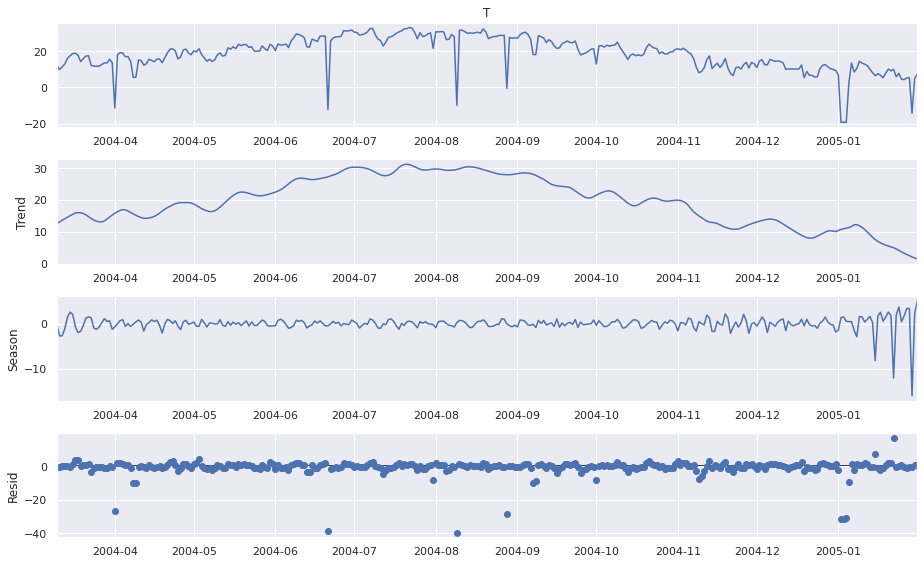

In [152]:
res = STL(df_stat_daily['T'], robust=True).fit()
res.plot()
plt.show()

- There is a upward non-linear trend in temperature from April to August, before the trend changes direction to become downwards. 
- The seasonality in the data does not appear to be very strong, and seems inconsistent.

##### Relative Humidity
Given that STL decomposition only supports additive transformation, we will use a classical multiplicative decomposition of the Relative Humidity time series.

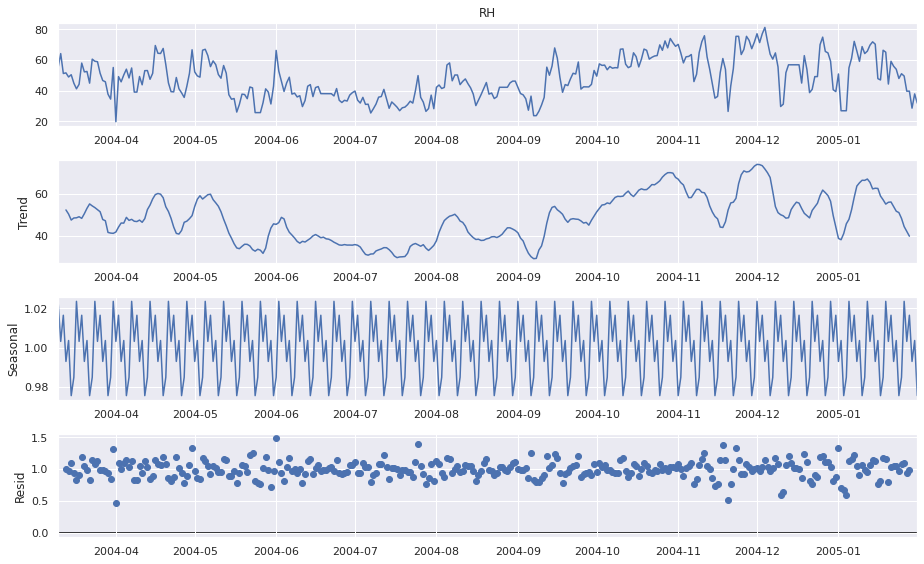

In [153]:
res = seasonal_decompose(df_stat_daily['RH'], 'multiplicative')
res.plot()
plt.show()

- There is a downward trend in relative humidity from April to August, before the trend changes direction to become downwards. The trend appears to be non-linear.
- It is clear that there is strong seasonality in the data, as even the trend appears to follow the seasonality after it is decomposed.

##### Carbon Monoxide

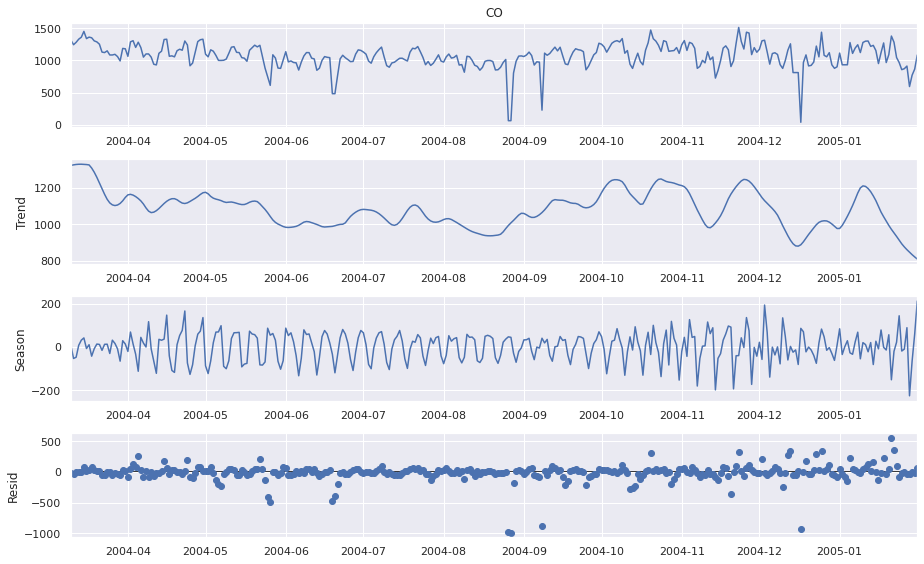

In [154]:
res = STL(df_stat_daily['CO'], robust=True).fit()
res.plot()
plt.show()

- The concentration of CO has a downward non-linear trend from April 2004 to August 2004, before changing direction to a upward trend from September 2004 to January 2005 (but the trend becomes weaker nearing the end of the year)
- There is a seasonality in the data, that appears to repeat every week, where the concentration rises and falls. This could correspond to increased edmissions during the weekdays compared to weekends.

##### Non Metanic Hydrocarbons

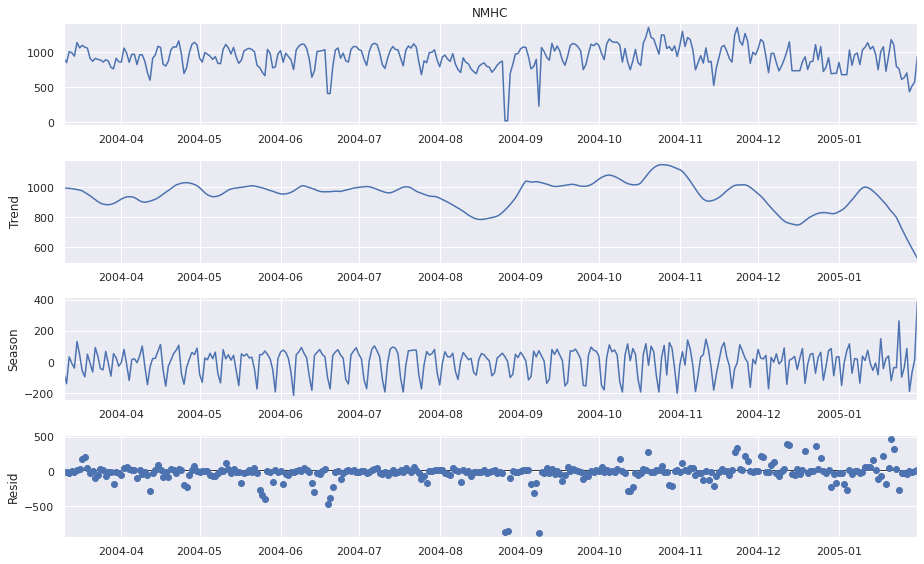

In [155]:
res = STL(df_stat_daily['NMHC'], robust=True).fit()
res.plot()
plt.show()

- The trend for NMHC is very weak, and does not appear to change significantly
- The seasonality is much stronger, with there being a cycle that seemingly corresponds to each week.

##### Nitrogen Oxides

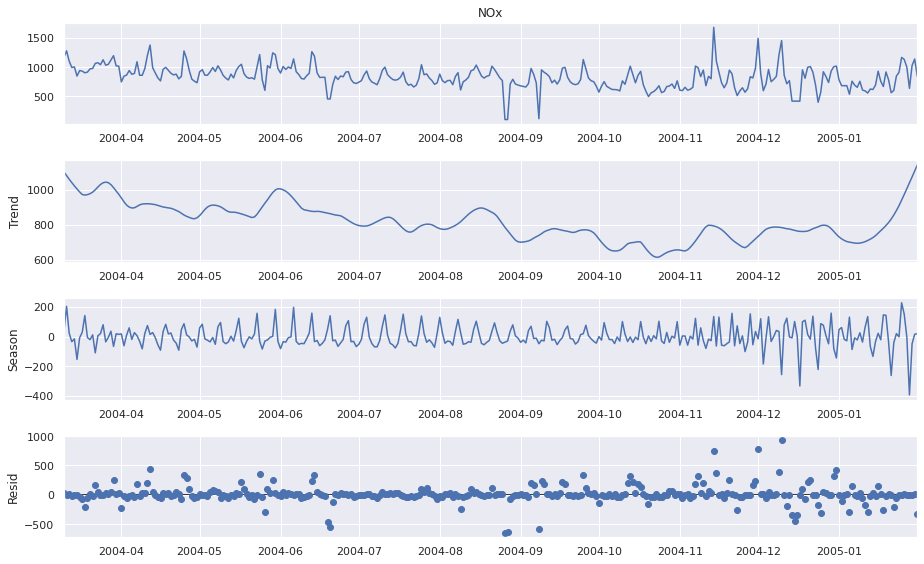

In [156]:
res = STL(df_stat_daily['NOx'], robust=True).fit()
res.plot()
plt.show()

- There is a non-linear downward trend between April 2004 to November 2004, before changing directions to an upward trend from December 2004 to January 2001. This suggests that emissions of Nitrogen Oxides have been decreasing over time.
- This is corroborated by referencing the emission trend of Nitrogen oxides in Italy, where there has been a sharp decrease in NOx emissions fromm 2000 to 2018. [Source](https://www.statista.com/statistics/809161/nitrogen-oxides-nox-emission-trend-in-italy/)
- According to the European Environment Agency, this is due to the installation of catalysts to vehicles during this period as per new EU standards, resulting in lower NOx emissions from vehicles. (47% of the reduction in NOx emissions from 1990 and 2011 come from vehicle emissions)  [Source](https://www.eea.europa.eu/data-and-maps/indicators/eea-32-nitrogen-oxides-nox-emissions-1/assessment.2010-08-19.0140149032-3#:~:text=The%20sectors%20responsible%20for%20the,distribution%27%20(contributing%2027%25).)

##### Ozone

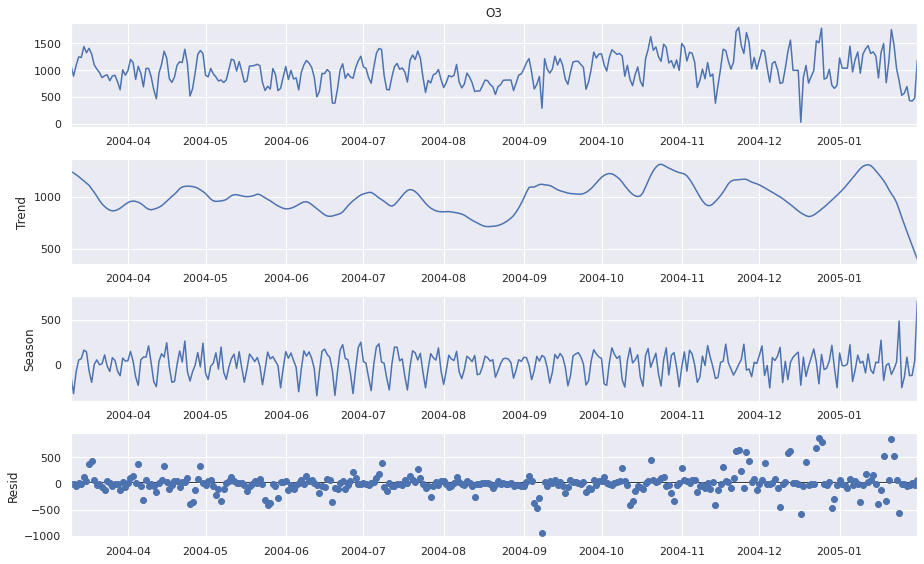

In [157]:
res = STL(df_stat_daily['O3'], robust=True).fit()
res.plot()
plt.show()

- The concentration of Ozone has a downward non-linear trend from April 2004 to August 2004, before changing direction to a upward trend from September 2004 to January 2005 

#### What is the strength of the trend and seasonality in the data?
It is useful for us to know how strong trend and seasonality are in our time series data, for later model selection and improvement.

[For strongly trended data, the seasonally adjusted data should have much more variation than the remainder component.](https://otexts.com/fpp2/seasonal-strength.html) Therefore $Var(R_t)/Var(T_t+R_t)$ should be relatively small. But for data with little or no trend, the two variances should be approximately the same. So the strength of trend is defined as
$$
F_t = \max (0, 1 - \frac{Var(R_t)}{Var(T_t + R_t)})
$$

Similarily, we define the strength of seasonality as
$$

F_s = \max (0, 1 - \frac{Var(R_t)}{Var(S_t + R_t)})

$$

In [158]:
trends, seasonality, residuals = [], [], []
for feature in df_stat_daily.drop('is_weekend', axis=1).columns:
    decomposition = STL(df_stat_daily[feature], robust=True).fit()
    trends.append(decomposition.trend)
    seasonality.append(decomposition.seasonal)
    residuals.append(decomposition.resid)

decompose_df = pd.DataFrame({
    "Var_Trend" : [trend.var() for trend in trends],
    "Var_Seasonality + Residual" : [(season + resid).var() for season, resid in zip(seasonality, residuals)],
    "Var_Trend + Residual" : [(trend + resid).var() for trend, resid in zip(trends, residuals)],
    "Var_Residuals":  [resid.var() for resid in residuals],
}, index = df_stat_daily.drop('is_weekend', axis=1).columns)
decompose_df

,Var_Trend,Var_Seasonality + Residual,Var_Trend + Residual,Var_Residuals
Gas,,,,
CO,10102.413936,23584.996228,35158.044584,21936.446830
NMHC,9388.893215,23747.347272,26748.766489,18336.321271
NOx,11085.555527,27198.962947,34876.283974,24251.980823
O3,22094.398174,52172.255083,65342.591996,39294.674300
T,56.985568,27.794144,82.386004,27.205173
RH,118.949552,66.441728,174.260273,63.499944


In [159]:
decompose_df['Trend Strength'] = decompose_df.apply(lambda feature : max(0, 1 - (feature['Var_Residuals'] / feature['Var_Trend + Residual'])), axis = 1)
decompose_df['Seasonal Strength'] = decompose_df.apply(lambda feature : max(0, 1 - (feature['Var_Residuals'] / feature['Var_Seasonality + Residual'])), axis = 1)
decompose_df

,Var_Trend,Var_Seasonality + Residual,Var_Trend + Residual,Var_Residuals,Trend Strength,Seasonal Strength
Gas,,,,,,
CO,10102.413936,23584.996228,35158.044584,21936.446830,0.376062,0.069898
NMHC,9388.893215,23747.347272,26748.766489,18336.321271,0.314498,0.227858
NOx,11085.555527,27198.962947,34876.283974,24251.980823,0.304628,0.108349
O3,22094.398174,52172.255083,65342.591996,39294.674300,0.398636,0.246828
T,56.985568,27.794144,82.386004,27.205173,0.669784,0.021190
RH,118.949552,66.441728,174.260273,63.499944,0.635603,0.044276


- We see that out of all of the gases, Ozone has the strongest trend and Seasonality, whilst Carbon Monoxide has a strong trend but weak seasonality

#### Checking Assumptions for Time Series Analysis
Before we can engage in modelling, we need to check if our data satisfies certain statistical assumptions that may be made by our models. This will inform us if further pre-processing (e.g Differencing is required for our data).

##### Stationarity
A stationary time series is one whose statistical properties do not depend on the time at which the series is observed. Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times. 

In general, a stationary time series will have no predictable patterns in the long-term. Time plots will show the series to be roughly horizontal (although some cyclic behaviour is possible), with constant variance.

[Source](https://otexts.com/fpp3/stationarity.html)



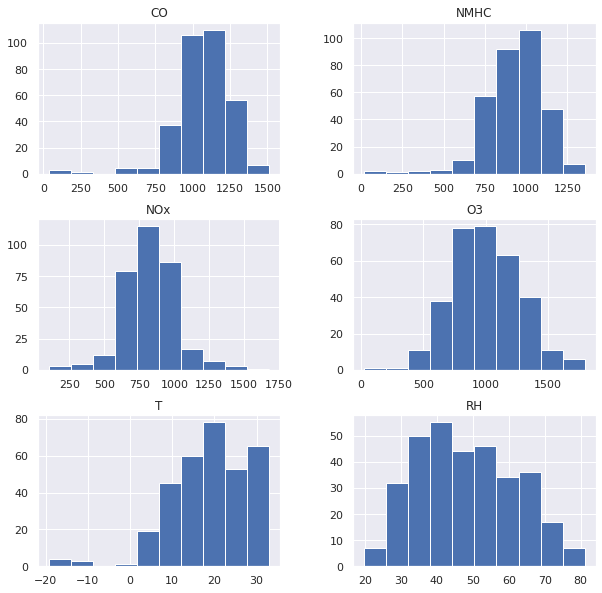

In [160]:
df_stat_daily.hist(figsize=(10, 10))
plt.show()

On a visual inspection, we note that the distribution of O3, NOx appears to look Normally Distributed, while that of CO and NMHC are negatively skewed due to the presence of outliers. 

Hence, the NOx and O3 time series data is likely stationary. We will need to do further checks on the stationarity. 

In [161]:
grp1 = df_stat_daily[:len(df_stat_daily) // 2]
grp2 = df_stat_daily[len(df_stat_daily) // 2:]

pd.concat([grp1.describe(), grp2.describe()], axis = 1)

Gas,CO,NMHC,NOx,O3,T,RH,CO,NMHC,NOx,O3,T,RH
count,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000
mean,1070.539168,927.128747,893.988758,938.395664,22.043941,42.732398,1070.373708,935.294398,764.400089,1064.613842,15.350572,53.801393
std,151.465286,134.985533,149.540845,221.182137,8.006580,10.502532,224.413944,211.780212,212.314480,307.849796,8.958539,13.570700
min,481.753472,408.704861,453.715278,382.131944,-12.148958,19.742014,36.281250,18.552083,102.520833,23.541667,-19.247917,23.669792
25%,988.820313,845.799479,796.906250,797.713542,16.907292,34.805469,949.422743,811.990451,644.192708,834.638889,10.103125,42.797396
50%,1059.015625,933.805556,873.776042,931.322917,22.357986,41.373785,1109.421875,963.611111,733.364583,1046.812500,15.054340,55.313715
75%,1158.091146,1034.760417,975.135417,1087.466146,28.783594,50.145139,1205.656250,1084.477431,884.520833,1296.317708,21.737326,64.554427
max,1452.010417,1163.041667,1376.031250,1439.041667,32.997917,69.340625,1513.208333,1355.104167,1678.687500,1795.291667,30.365625,81.104167


###### ADF Test
ADF test is used to determine the presence of unit root in the series, and hence helps in understand if the series is stationary or not. The null and alternate hypothesis of this test are:

Null Hypothesis: The series has a unit root.

Alternate Hypothesis: The series has no unit root.

If the null hypothesis failed to be rejected, this test may provide evidence that the series is non-stationary.

[Reference: Statsmodels](https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html)


In [162]:
def adf_test(series, significance_level = 0.05):
    print(f"Test for Stationarity\nSignificance Level: {significance_level}\nH0: There is a unit root (non-stationary time series)\nH1: There is no unit root (stationary time series)")
    test_statistic, pvalue, usedlag, *_ = adfuller(series)
    print(f"P-value: {pvalue:.3f}")
    print(f"Used Lag: {usedlag}")
    if pvalue < significance_level:
        print("Reject H0. There is evidence that the time series is stationary.")
    else:
        print("Fail to reject H0. There is insufficient evidence that the time series is stationary.")
    return test_statistic, pvalue, usedlag

In [163]:
for gas in df_stat_daily.columns:
    print(gas)
    adf_test(df_stat_daily[gas])

CO
Test for Stationarity
Significance Level: 0.05
H0: There is a unit root (non-stationary time series)
H1: There is no unit root (stationary time series)
P-value: 0.000
Used Lag: 0
Reject H0. There is evidence that the time series is stationary.
NMHC
Test for Stationarity
Significance Level: 0.05
H0: There is a unit root (non-stationary time series)
H1: There is no unit root (stationary time series)
P-value: 0.000
Used Lag: 7
Reject H0. There is evidence that the time series is stationary.
NOx
Test for Stationarity
Significance Level: 0.05
H0: There is a unit root (non-stationary time series)
H1: There is no unit root (stationary time series)
P-value: 0.000
Used Lag: 1
Reject H0. There is evidence that the time series is stationary.
O3
Test for Stationarity
Significance Level: 0.05
H0: There is a unit root (non-stationary time series)
H1: There is no unit root (stationary time series)
P-value: 0.000
Used Lag: 8
Reject H0. There is evidence that the time series is stationary.
T
Test fo

###### KPSS Test
KPSS is another test for checking the stationarity of a time series. The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.

Null Hypothesis: The process is trend stationary.

Alternate Hypothesis: The series has a unit root (series is not stationary).

We apply this test in addition to the ADF test, to ensure that our data is truly stationary.

In [164]:
def kpss_test(series, significance_level = 0.05):
    print(f"Test for Stationarity\nSignificance Level: {significance_level}\nH0: Process is trend stationary\nH1: There is a unit root (non-stationary)")
    test_statistic, pvalue, usedlag, *_ = kpss(series, regression="c", nlags="auto")
    print(f"P-value: {pvalue:.3f}")
    print(f"Used Lag: {usedlag}")
    if pvalue < significance_level:
        print("Reject H0. There is evidence that the time series is not stationary.")
    else:
        print("Fail to reject H0. There is insufficient evidence that the time series is not stationary.")
    return test_statistic, pvalue, usedlag

In [165]:
for gas in df_stat_daily.columns:
    print(gas)
    kpss_test(df_stat_daily[gas])

CO
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.100
Used Lag: 8
Fail to reject H0. There is insufficient evidence that the time series is not stationary.
NMHC
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.100
Used Lag: 7
Fail to reject H0. There is insufficient evidence that the time series is not stationary.
NOx
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.010
Used Lag: 7
Reject H0. There is evidence that the time series is not stationary.
O3
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.025
Used Lag: 8
Reject H0. There is evidence that the time series is not stationary.
T
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stati

/home/tiencheng/mambaforge/envs/aiml/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/home/tiencheng/mambaforge/envs/aiml/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/home/tiencheng/mambaforge/envs/aiml/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


/home/tiencheng/mambaforge/envs/aiml/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning:

The test statistic is outside of the range of p-values available in th

For O3 and NOx, we note that KPSS indicates the data is non-stationary, but the ADF test indicates it is stationary. The series is thus inferred to be difference stationary. 

We will difference the data, and check the differenced data for stationarity.

In [173]:
print("Results of KPSS Test on Differenced Series (O3)")
kpss_test(diff(df_stat_daily['O3']))

print("Results of ADF Test on Differenced Series (O3)")
adf_test(diff(df_stat_daily['O3']))

print("Results of KPSS Test on Differenced Series (NOx)")
kpss_test(diff(df_stat_daily['NOx']))


print("Results of ADF Test on Differenced Series (NOx)")
adf_test(diff(df_stat_daily['NOx']))

Results of KPSS Test on Differenced Series (O3)
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.100
Used Lag: 35
Fail to reject H0. There is insufficient evidence that the time series is not stationary.
Results of ADF Test on Differenced Series (O3)
Test for Stationarity
Significance Level: 0.05
H0: There is a unit root (non-stationary time series)
H1: There is no unit root (stationary time series)
P-value: 0.000
Used Lag: 11
Reject H0. There is evidence that the time series is stationary.
Results of KPSS Test on Differenced Series (NOx)
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.100
Used Lag: 68
Fail to reject H0. There is insufficient evidence that the time series is not stationary.
Results of ADF Test on Differenced Series (NOx)
Test for Stationarity
Significance Level: 0.05
H0: There is a unit root (non-stationa

/home/tiencheng/mambaforge/envs/aiml/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/home/tiencheng/mambaforge/envs/aiml/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




(-11.331600537208386, 1.1092542125978076e-20, 6)

We observe that after detrending via differencing, the KPSS test shows that O3 and NOx are now truly stationary.

#### Autocorrelation
Autocorrelation measures the linear relationship between lagged values of a time series. Understanding the autocorrelation of a time series at different lags helps us the values of p (order) of an autoregressive model.

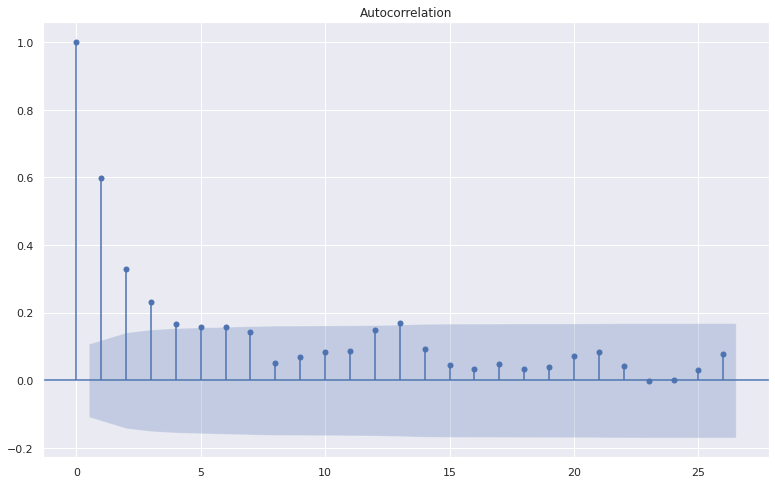

In [167]:
plot_acf(df_stat_daily['CO'])
plt.show()

- For CO, it appears that 4 MA terms would be best, as we have lag 1, 2, 3 and 4 out of the confidence interval of the ACF plot

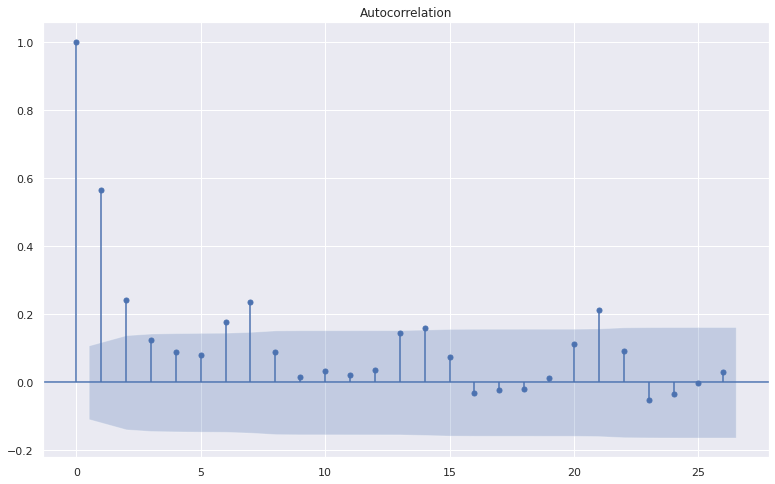

In [169]:
plot_acf(df_stat_daily['NMHC'])
plt.show()

- For NMHC, we observe that Lag 1 and Lag 2 are outside of the confidence interval, suggesting 2 MA terms.

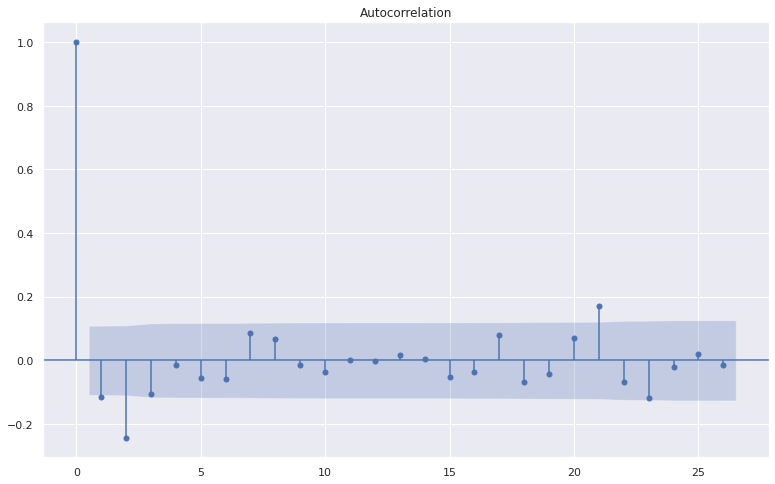

In [174]:
plot_acf(diff(df_stat_daily['NOx']))
plt.show()

- For NOx, we estimate that there is 1 MA term, as lag 2 is outside of the confidence interval

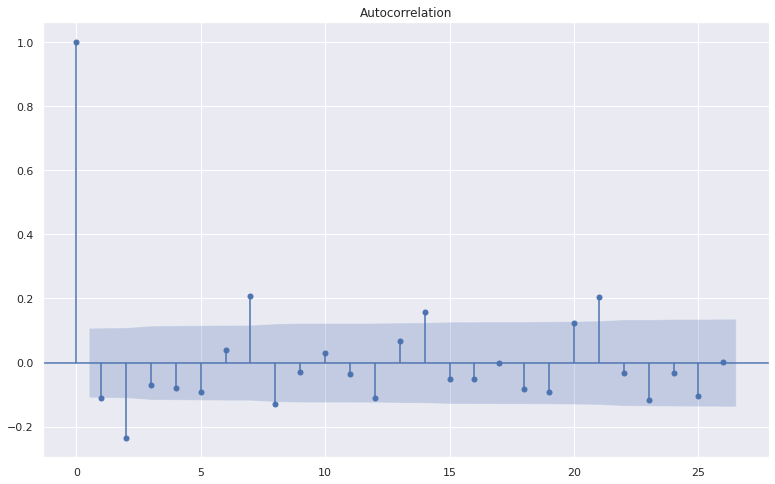

In [171]:
plot_acf(diff(df_stat_daily['O3']))
plt.show()

- For O3, we estimate that there is 1 MA term, as lag 2 is outside of the confidence interval

#### Partial Autocorrelation

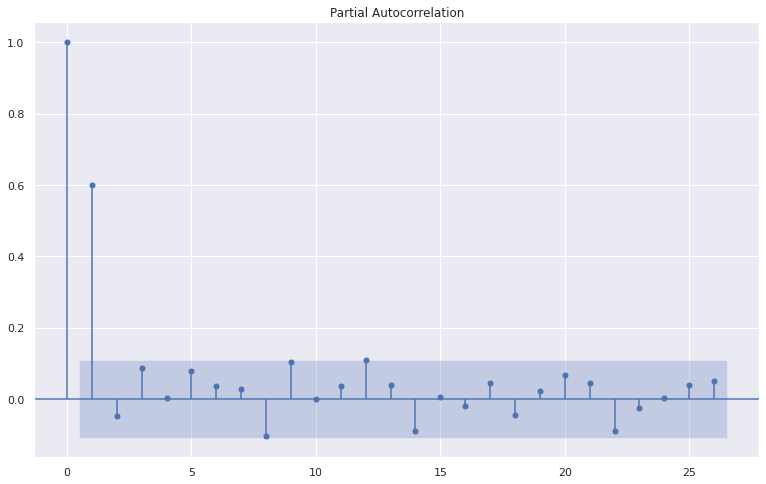

In [177]:
plot_pacf(df_stat_daily['CO'])
plt.show()

- Lag 1 is outside of the confidence interval, suggesting 1 AR term for CO

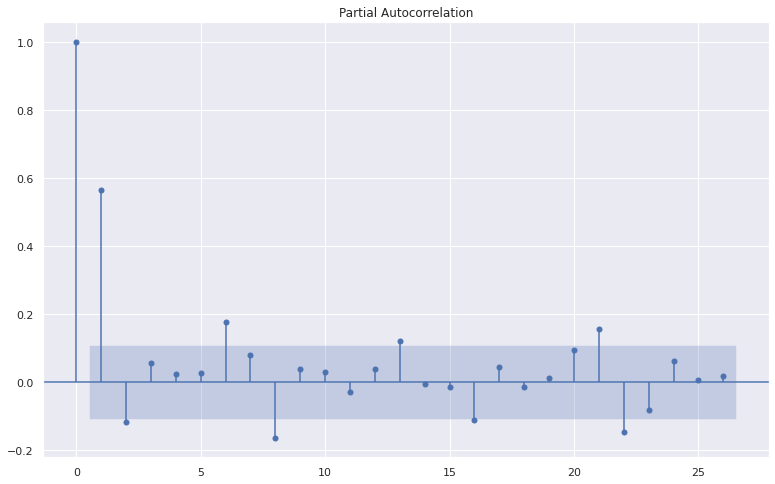

In [179]:
plot_pacf(df_stat_daily['NMHC'])
plt.show()

- Lag 1 is outside of the confidence interval, suggesting 1 AR term for NMHC

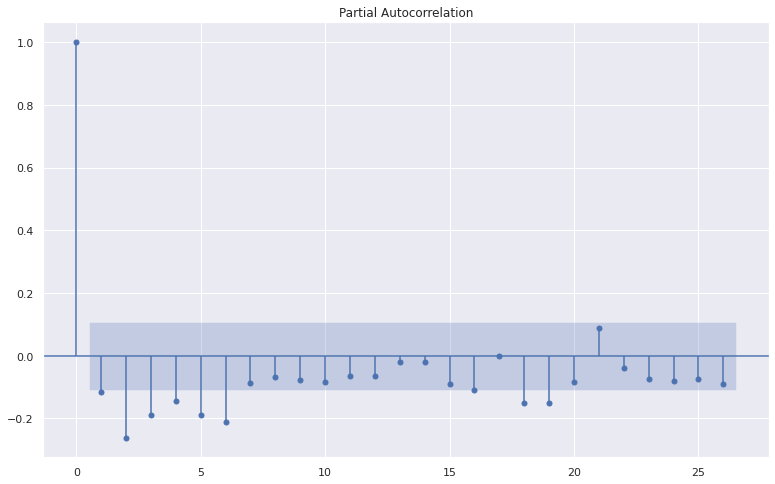

In [183]:
plot_pacf(diff(df_stat_daily['NOx']))
plt.show()

- There are an estimated 6 terms for AR, as Lag 1, 2, 3, 4, 5, 6 are outside of the confidence interval

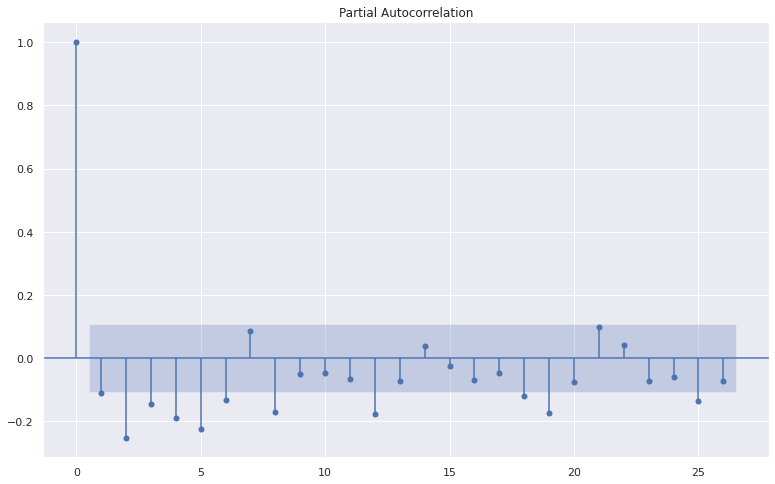

In [181]:
plot_pacf(diff(df_stat_daily['O3']))
plt.show()

- There are an estimated 6 AR terms for Ozone, as Lag 1, 2, 3, 4, 5, 6 are outside of the confidence interval.

## Data Pre-processing

In [186]:
def DataPreprocess(dataset, train = True, impute = True):
    out_of_range_RH = (dataset['RH'] < 10) | (dataset['RH'] > 90)
    out_of_range_temp = (dataset['T'] < -20) | (dataset['T'] > 50) 
    dataset.loc[out_of_range_temp, 'T'] = np.nan
    dataset.loc[out_of_range_RH, 'RH'] = np.nan
    if train:
        impossible_Value = dataset['Value'] < 0
        dataset.loc[impossible_Value, 'Value'] = np.nan
        dataset_transformed = pd.pivot(dataset, values="Value", columns="Gas")
        dataset_transformed[["T", "RH"]] = dataset[["T", "RH"]].groupby(dataset.index).mean()
    else:
        dataset_transformed = dataset
    if impute:
        dataset_transformed = dataset_transformed.fillna(method='ffill')
    return dataset_transformed

In [187]:
train = DataPreprocess(df)
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 328 entries, 2004-03-10 to 2005-01-31
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CO      328 non-null    float64
 1   NMHC    328 non-null    float64
 2   NOx     328 non-null    float64
 3   O3      328 non-null    float64
 4   T       328 non-null    float64
 5   RH      328 non-null    float64
dtypes: float64(6)
memory usage: 17.9 KB


## Forecasting

### Uni-variate Time Series

In [242]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [245]:
def multi_step_predict(model, existing_data, start, end, model_params = {}):
    """
    Does multi-step time series prediction, where the model is refitted for every new prediction.
    """
    forecasts = []
    data = existing_data
    for date in pd.date_range(start, end):
        cur_model = model(data, **model_params).fit()
        forecast = cur_model.predict(start=date).values[0]
        forecasts.append(forecast)
        data.append(pd.Series(forecast))
    return forecasts, cur_model

In [ ]:
def eval_model(model, dataset, model_params, cv = TimeSeriesSplit(3))

In [255]:
for tidx, testidx in TimeSeriesSplit(3).split(train):
    print(len(tidx))

82
164
246


In [192]:
gases = {'CO', 'NMHC', 'NOx', 'O3'}

In [250]:
cv = TimeSeriesSplit()
cv_metrics = {
    'train_rmse' : [],
    'test_rmse' : [],
    'corrected aic' : [],
    'gas' : []
}

for gas in gases:
    for train_idx, test_idx in cv.split(train):
        train_set = train[gas].iloc[train_idx].fillna(method='ffill')
        test_set = train[gas].iloc[test_idx].fillna(method='ffill')
        model = ExponentialSmoothing
        res = model(train_set).fit()
        cv_metrics['corrected aic'].append(res.aicc)
        train_predictions = res.predict(start=train_set.index[0], end=train_set.index[-1])
        rmse_train = np.sqrt(mean_squared_error(train_set, train_predictions))
        cv_metrics['train_rmse'].append(rmse_train)
        test_predictions, final_model = multi_step_predict(model, train_set, test_set.index[0], test_set.index[-1])
        rmse_test = np.sqrt(mean_squared_error(test_set, test_predictions))
        cv_metrics['test_rmse'].append(rmse_test)
        cv_metrics['gas'].append(gas)
cv_metrics = pd.DataFrame(cv_metrics)

In [252]:
cv_metrics.mean()

train_rmse        154.161742
test_rmse         237.681419
corrected aic    1682.565402
dtype: float64

In [251]:
cv_metrics.groupby('gas').describe().T

gas                           CO         NMHC          NOx           O3
train_rmse    count     5.000000     5.000000     5.000000     5.000000
              mean    129.021942   140.544939   144.089998   202.990089
              std      22.897673    20.245012    15.660556     7.852085
              min     105.269814   114.533805   128.999038   192.765072
              25%     110.310418   128.104470   130.128607   200.560717
              50%     123.486124   138.874823   142.644875   201.233419
              75%     152.628467   160.140900   152.585284   206.371813
              max     153.414887   161.070697   166.092185   214.019423
test_rmse     count     5.000000     5.000000     5.000000     5.000000
              mean    211.062717   204.222223   210.039201   325.401534
              std      62.675659    55.124265    61.838963    62.520475
              min     160.666371   159.746854   127.126328   225.112828
              25%     175.177480   174.968066   184.857763   309.232306
              50%     175.808307   176.770299   216.974116   347.661349
              75%     231.475794   213.289324   224.405118   358.647279
              max     312.185632   296.336574   296.832678   386.353907
corrected aic count     5.000000     5.000000     5.000000     5.000000
              mean   1634.421720  1661.246374  1664.981574  1769.611938
              std     880.747511   885.304206   881.732204   915.227037
              min     544.911815   554.695639   569.503413   622.997534
              25%    1083.186681  1109.494178  1115.494058  1192.574108
              50%    1565.743507  1615.393352  1617.703690  1751.057219
              75%    2218.770255  2237.649829  2216.384466  2336.677539
              max    2759.496342  2788.998871  2805.822245  2944.753290

In [208]:
train_idx

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57])

In [247]:
cv = TimeSeriesSplit()

cv_metrics = {
    'train_rmse' : [],
    'test_rmse' : [],
    'corrected aic' : [],
    'gas' : []
}
orders = {
    "CO" : {
        "AR" : 1,
        "MA" : 4,
        "Diff" : 0
    },
    "NMHC" : {
        "AR" : 1,
        "MA" : 2,
        "Diff" : 0
    },
    "NOx" : {
        "AR" : 6,
        "MA" : 1,
        "Diff" : 1
    },
    "O3" : {
        "AR" : 6,
        "MA" : 1,
        "Diff" : 1
    }
}
for gas in gases:
    print(gas)
    order = (orders[gas]['AR'], orders[gas]['Diff'], orders[gas]['MA'])
    print(order)
    cv = TimeSeriesSplit()
    for train_idx, test_idx in cv.split(train):
            train_set = train[gas].iloc[train_idx]
            test_set = train[gas].iloc[test_idx]
            model = ARIMA
            res = model(train_set, order=order).fit()
            cv_metrics['corrected aic'].append(res.aicc)
            train_predictions = res.predict(start=train_set.index[0 + order[1]], end=train_set.index[-1])
            rmse_train = np.sqrt(mean_squared_error(train_set[0 + order[1]:], train_predictions))
            cv_metrics['train_rmse'].append(rmse_train)
            test_predictions, final_model = muflti_step_predict(model, train_set, test_set.index[0], test_set.index[-1], model_params={'order' : order})
            rmse_test = np.sqrt(mean_squared_error(test_set, test_predictions))
            cv_metrics['test_rmse'].append(rmse_test)
            cv_metrics['gas'].append(gas)
cv_metrics = pd.DataFrame(cv_metrics)

NOx
(6, 1, 1)
NMHC
(1, 0, 2)
O3
(6, 1, 1)
CO
(1, 0, 4)


In [249]:
cv_metrics.mean()

train_rmse        132.907934
test_rmse         220.846241
corrected aic    2111.220575
dtype: float64

In [248]:
cv_metrics.groupby('gas').describe().T

gas                           CO         NMHC          NOx           O3
train_rmse    count     5.000000     5.000000     5.000000     5.000000
              mean    114.867358   116.911570   127.809580   172.043229
              std      21.452452    22.281227    15.049796    10.508989
              min      90.983482    90.090769   112.100247   158.898746
              25%      99.049584   105.643180   117.793413   170.057736
              50%     109.946755   108.780812   124.035108   170.140978
              75%     136.728946   138.404572   135.159980   172.931470
              max     137.628025   141.638517   149.959154   188.187214
test_rmse     count     5.000000     5.000000     5.000000     5.000000
              mean    200.040934   184.894115   187.291716   311.158200
              std      60.298632    43.517939    55.161412    72.584077
              min     104.168290   126.858198    99.718846   226.355384
              25%     178.081811   158.328563   165.215892   237.184785
              50%     230.475135   196.630606   221.846586   362.842997
              75%     235.849051   202.499100   224.065361   363.186860
              max     251.630383   240.154110   225.611894   366.220975
corrected aic count     5.000000     5.000000     5.000000     5.000000
              mean   2077.571403  2082.800336  2096.961344  2187.549217
              std    1105.288998  1112.494100  1105.762570  1135.579137
              min     703.673133   698.305046   724.451388   768.424248
              25%    1384.319568  1379.626508  1402.991512  1472.780081
              50%    2008.645513  2029.160657  2042.663785  2157.557388
              75%    2804.801972  2804.303657  2787.438384  2887.884640
              max    3486.416828  3502.605812  3527.261652  3651.099727

## Prediction

In [ ]:
def generate_submission():
    

In [ ]:
test_df = pd.read_csv("test.csv", index_col=0, na_values=[-200])
test_df["Date"] = pd.to_datetime(test_df["Date"], format="%d/%m/%Y")
test_df

In [ ]:
test_df.info()

In [ ]:
test = DataPreprocess(test_df, train=False)
test.info()

In [ ]:
test

In [ ]:
model = ExponentialSmoothing
preds = []
for gas in test['Gas'].unique():
    print(gas)
    series = test[test['Gas'] == gas]
    test_predictions, final_model = multi_step_predict(model, train[gas], test['Date'].iloc[0], test['Date'].iloc[-1])
    preds.append(test_predictions)

preds = np.array(preds).flatten()
preds[:5]

In [ ]:
submit_df = pd.DataFrame({
    'id' : test.index,
    'Value' : preds
})
submit_df

In [ ]:
date.day

In [ ]:
date = pd.to_datetime("now")
submit_df.to_csv(f"./submissions/submission-{date}.csv", index = False)